In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import pandas as pd
import os
import sys
import time
import tensorflow as tf

from tensorflow import keras

print(tf.__version__)
print(sys.version_info)
for module in mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)

2.2.0
sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)
matplotlib 3.2.1
numpy 1.18.5
pandas 1.0.4
sklearn 0.23.1
tensorflow 2.2.0
tensorflow.keras 2.3.0-tf


In [2]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
print(housing.DESCR)
print(housing.data.shape)
print(housing.target.shape)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [3]:
from sklearn.model_selection import train_test_split

x_train_all, x_test, y_train_all, y_test = train_test_split(
    housing.data, housing.target, random_state = 7)
x_train, x_valid, y_train, y_valid = train_test_split(
    x_train_all, y_train_all, random_state = 11)
print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


(11610, 8) (11610,)
(3870, 8) (3870,)
(5160, 8) (5160,)


In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_valid_scaled = scaler.transform(x_valid)
x_test_scaled = scaler.transform(x_test)

In [12]:
# RandomizedSearchCV
# 1. 因为是sklearn的接口，转化为sklearn的model
# 2. 定义参数集合
# 3. 搜索参数

def build_model(hidden_layers = 1,
                layer_size = 30,
                learning_rate = 3e-3):
    model = keras.models.Sequential()
    #因为不知道第一个输入的shape是多大的，因此我们需要单独从for循环里拿出来，for循环里的是输出再次作为输入
    model.add(keras.layers.Dense(layer_size, activation='relu',
                                 input_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,
                                     activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate)
    model.compile(loss = 'mse', optimizer = optimizer)
    return model

#KerasRegressor返回一个sk的model,build_fn是一个回调函数
sklearn_model = tf.keras.wrappers.scikit_learn.KerasRegressor(
    build_fn = build_model)
callbacks = [keras.callbacks.EarlyStopping(patience=5, min_delta=1e-2)]
#这是对sk封装tf的一个测试
history = sklearn_model.fit(x_train_scaled, y_train,
                            epochs = 10,
                            validation_data = (x_valid_scaled, y_valid),
                            callbacks = callbacks)

Epoch 1/10
363/363 [==============================] - 1s 3ms/step - loss: 1.1589 - val_loss: 0.6761
Epoch 2/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5793 - val_loss: 0.5976
Epoch 3/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5289 - val_loss: 0.5529
Epoch 4/10
363/363 [==============================] - 1s 2ms/step - loss: 0.5031 - val_loss: 0.5220
Epoch 5/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4866 - val_loss: 0.5108
Epoch 6/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4731 - val_loss: 0.5005
Epoch 7/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4650 - val_loss: 0.4881
Epoch 8/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4550 - val_loss: 0.4793
Epoch 9/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4503 - val_loss: 0.4703
Epoch 10/10
363/363 [==============================] - 1s 2ms/step - loss: 0.4459 - val_loss: 0.4664

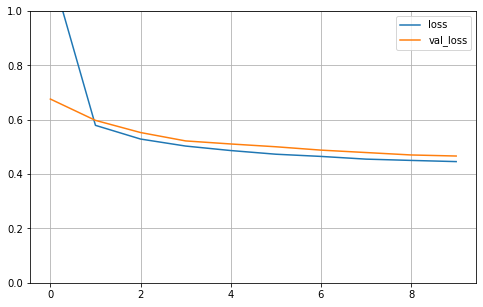

In [13]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()
plot_learning_curves(history)

In [15]:
#scipy也是sk中的
from scipy.stats import reciprocal
# 分布函数
# f(x) = 1/(x*log(b/a)) a <= x <= b

#sk 0.21.3版本可以用这种列表
# param_distribution = {
#     "hidden_layers":[1, 2, 3, 4],
#     "layer_size": np.arange(1, 100),
#     "learning_rate": reciprocal(1e-4, 1e-2),
# }
#最新版本只能用普通列表
param_distribution = {
    "hidden_layers": [1, 2, 3, 4],
    "layer_size": [5, 10, 20, 30],
    "learning_rate": [1e-4, 5e-5, 1e-3, 5e-3, 1e-2],
}

from sklearn.model_selection import RandomizedSearchCV,GridSearchCV

#随机搜索
random_search_cv = RandomizedSearchCV(sklearn_model,
                                      param_distribution)
# grid_search_cv =GridSearchCV(sklearn_model,param_distribution)
random_search_cv.fit(x_train_scaled, y_train, epochs = 5,
                     validation_data = (x_valid_scaled, y_valid),
                     callbacks = callbacks)

# grid_search_cv.fit(x_train_scaled, y_train, epochs = 5,
#                      validation_data = (x_valid_scaled, y_valid),
#                      callbacks = callbacks)
# cross_validation: 训练集分成n份，n-1训练，最后一份验证.

Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 2.5673 - val_loss: 1.3176
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9976 - val_loss: 0.9028
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8543 - val_loss: 0.8199
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.7668 - val_loss: 0.7744
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.6883
Epoch 1/5
291/291 [==============================] - 1s 3ms/step - loss: 3.2080 - val_loss: 1.6667
Epoch 2/5
291/291 [==============================] - 1s 3ms/step - loss: 1.3373 - val_loss: 1.2896
Epoch 3/5
291/291 [==============================] - 1s 3ms/step - loss: 1.1369 - val_loss: 1.1174
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9867 - val_loss: 0.9578
Epoch 5/5
73/73 [==============================] - 0s 2ms/step - loss: 0.7811
Epoch 1/5
291/291 [==============================] -

291/291 [==============================] - 1s 2ms/step - loss: 3.3569 - val_loss: 3.2894
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 2.7249
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 0.9152 - val_loss: 0.8246
Epoch 2/5
291/291 [==============================] - 0s 2ms/step - loss: 0.9611 - val_loss: 0.6179
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4892 - val_loss: 0.4735
Epoch 4/5
291/291 [==============================] - 0s 2ms/step - loss: 0.4338 - val_loss: 0.4311
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.3756
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 1.9506 - val_loss: 1.1111
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 1.9712 - val_loss: 1.0793
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.4878 - val_loss: 0.4803
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 1.9418 - val_loss: 0.9647
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6986 - val_loss: 0.6178
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5567 - val_loss: 0.5488
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.5597 - val_loss: 0.5208
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.4633
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 5.3473 - val_loss: 5.1031
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 4.5334 - val_loss: 4.3685
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.9186 - val_loss: 3.8053
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 3.4376 - val_loss: 3.3595
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 3.0499
Epoch 1/5
291/291 [==============================] - 1s 2ms/st

291/291 [==============================] - 1s 2ms/step - loss: 0.6565 - val_loss: 0.6986
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6456
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 2.5076 - val_loss: 1.0345
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 0.8722 - val_loss: 0.7935
Epoch 3/5
291/291 [==============================] - 0s 2ms/step - loss: 0.6857 - val_loss: 0.7203
Epoch 4/5
291/291 [==============================] - 1s 2ms/step - loss: 0.6439 - val_loss: 0.6924
Epoch 5/5
73/73 [==============================] - 0s 1ms/step - loss: 0.6347
Epoch 1/5
291/291 [==============================] - 1s 2ms/step - loss: 4.0956 - val_loss: 3.9248
Epoch 2/5
291/291 [==============================] - 1s 2ms/step - loss: 3.5114 - val_loss: 3.3692
Epoch 3/5
291/291 [==============================] - 1s 2ms/step - loss: 3.0059 - val_loss: 2.9053
Epoch 4/5
291/291 [==============================] - 1s 2ms/st

RandomizedSearchCV(estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7fc9d70680f0>,
                   param_distributions={'hidden_layers': [1, 2, 3, 4],
                                        'layer_size': [5, 10, 20, 30],
                                        'learning_rate': [0.0001, 5e-05, 0.001,
                                                          0.005, 0.01]})

In [17]:
print(random_search_cv.best_params_)
print(random_search_cv.best_score_)
print(random_search_cv.best_estimator_)

# print(grid_search_cv.best_params_)
# print(grid_search_cv.best_score_)
# print(grid_search_cv.best_estimator_)

{'learning_rate': 0.01, 'layer_size': 30, 'hidden_layers': 2}
-0.4073116958141327


In [16]:
model = random_search_cv.best_estimator_.model
model.evaluate(x_test_scaled, y_test)

# model = grid_search_cv.best_estimator_.model
# model.evaluate(x_test_scaled, y_test)

162/162 [==============================] - 0s 1ms/step - loss: 0.3895


0.3894803524017334